<a href="https://colab.research.google.com/github/Mmengyw/Capstone-Updated/blob/main/Depth%20Prediction/DepthPrediction_to_PointCloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Packages

In [ ]:
# Tensorflow
import tensorflow.compat.v1 as tf
print(tf.__version__)

# I/O libraries
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

# Helper libraries
import matplotlib
import torch
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
from tqdm import tqdm
import IPython
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

# Comment this out if you want to see Deprecation warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
#test


2.8.0


In [ ]:
pip install timm

     |████████████████████████████████| 431 kB 5.4 MB/s 


# Functions for Image Segmentation

In [ ]:
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""

    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        graph_def = None

        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.Session(graph=self.graph)

    def run(self, image, INPUT_TENSOR_NAME = 'ImageTensor:0', OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'):
        """Runs inference on a single image.

        Args:
            image: A PIL.Image object, raw input image.
            INPUT_TENSOR_NAME: The name of input tensor, default to ImageTensor.
            OUTPUT_TENSOR_NAME: The name of output tensor, default to SemanticPredictions.

        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        target_size = (2049,1025)  # size of Cityscapes images
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            OUTPUT_TENSOR_NAME,
            feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]  # expected batch size = 1
        if len(seg_map.shape) == 2:
            seg_map = np.expand_dims(seg_map,-1)  # need an extra dimension for cv.resize
        seg_map = cv.resize(seg_map, (width,height), interpolation=cv.INTER_NEAREST)
        return seg_map

In [ ]:
def create_label_colormap():
    """Creates a label colormap used in Cityscapes segmentation benchmark.

    Returns:
        A Colormap for visualizing segmentation results.
    """
    colormap = np.array([
        [128,  64, 128],
        [244,  35, 232],
        [ 70,  70,  70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170,  30],
        [220, 220,   0],
        [107, 142,  35],
        [152, 251, 152],
        [ 70, 130, 180],
        [220,  20,  60],
        [255,   0,   0],
        [  0,   0, 142],
        [  0,   0,  70],
        [  0,  60, 100],
        [  0,  80, 100],
        [  0,   0, 230],
        [119,  11,  32],
        [  0,   0,   0]], dtype=np.uint8)
    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
            is the color indexed by the corresponding element in the input label
            to the PASCAL color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
            map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(20, 4))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])

COLOR_MAP = np.array([
    [128,  64, 128],
    [244,  35, 232],
    [ 70,  70,  70],
    [102, 102, 156],
    [190, 153, 153],
    [153, 153, 153],
    [250, 170,  30],
    [220, 220,   0],
    [107, 142,  35],
    [152, 251, 152],
    [ 70, 130, 180],
    [220,  20,  60],
    [255,   0,   0],
    [  0,   0, 142],
    [  0,   0,  70],
    [  0,  60, 100],
    [  0,  80, 100],
    [  0,   0, 230],
    [119,  11,  32],
    [  0,   0,   0]], dtype=np.uint8)

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [ ]:
MODEL_NAME = 'mobilenetv2_coco_cityscapes_trainfine'
#MODEL_NAME = 'xception65_cityscapes_trainfine'

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_cityscapes_trainfine':
        'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
    'xception65_cityscapes_trainfine':
        'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


# Initialize Midas

In [ ]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Downloading: "https://github.com/intel-isl/MiDaS/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt" to /root/.cache/torch/hub/checkpoints/dpt_large-midas-2f21e586.pt


  0%|          | 0.00/1.28G [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=4

In [ ]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!git clone https://github.com/Mmengyw/Capstone-Updated.git
!ls
os.chdir("Capstone-Updated/Videos")

Cloning into 'Capstone-Updated'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 130 (delta 59), reused 14 (delta 5), pack-reused 18
Receiving objects: 100% (130/130), 105.56 MiB | 7.16 MiB/s, done.
Resolving deltas: 100% (60/60), done.
Capstone-Updated  sample_data


# Conversion to meters

In [ ]:
nb_photo=34

equiv=[[0.001,51],    #for extrapolation
      [0.1,45],     #premier plan
      [0.9,42.3],
      [1.8,37.4],
      [2.7,28.7],
      [3.6,24.443365],
      [4.5,22.058018],
      [5.4,15.317413],
      [6.3,14.677493],
      [7.2,10.969739],
      [8.1,10.883035],
      [9,9.883035],
      [9.9,8.058806],
      [10.8,7.5158963],
      [11.7,7.098169],
      [12.6,6.111024],
      [13.5,5.6323136],
      [14.4,5.2216917],
      [15.3,5],
      [16.2,4.9529667],
      [17.1,4.8],
      [18,4.7],
      [18.9,4.6],
      [19.8,4.5],
      [20.7,4.4],
      [21.6,4.3],
      [22.5,4.2],
      [23.4,4.1],
      [24.3,4],
      [25.2,3.9],
      [26.1,3.8],
      [27,3.7],
      [27.9,3.6],
      [28.8,3.5],
      [29.7,3.2],
      [30.6,3],
      [60,0.0],
       
      [120,-6],    #horizon
       
      [40,1.98],
      [50,1.33]
       
       ]   #for extrapolation

#=========================================================================================

equiv2=[[1,41.05157], #1yard  0302
        [1,42.18351],
        [1,31.304607],
        [1,25.090006],
        [1,23.275448], #5yard 0306
        [1,19.171278],
        [1,17.472866],
        [1,16.775742],
        [1,15.820402],
        [1,15.538459], #10yard  0311
        [1,14.466544],
        [1,12.707126],
        [1,10.957558],
      

        [1,6.023936],#'''inacurrate'''
        [1,9.797453],  #15yard 0316
        [1,7.2150397],
        [1,6.3944836],
        [1,8.514687],
        [1,7.735209],
        ]

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline
equiv=np.asarray(equiv)
X = equiv[:,1]    #midas output
Y=equiv[:,0]     #meters
new_length = 25
new_x = np.linspace(X.min(), X.max(), new_length)
conv=sp.interpolate.interp1d(X, Y, kind='linear')

#Increased contrast
Just to get increased contrast, not values in meters

In [ ]:
coef_expand=[[-5,-1],
        [1,10],
        [5,25],
        [10,35],
        [15,42],
        [35,43],
        [45,50],
        [51,51]
        ]
coef_expand=np.asarray(coef_expand)
X = coef_expand[:,0]    #midas output
Y=coef_expand[:,1]      #meters
expand=sp.interpolate.interp1d(X, Y, kind='cubic')

# Depth Prediction function

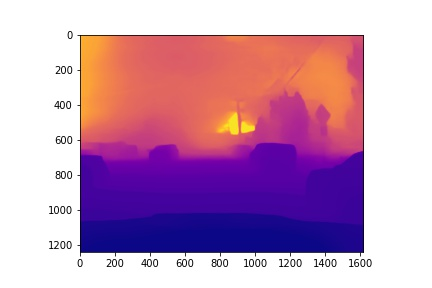

In [ ]:
!ls
def depth_prediction_stream(image, frame, index):
    """Visualizes segmentation overlay view and stream it with IPython display."""
    img = frame
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    input_batch = transform(img).to(device)

    with torch.no_grad():
      prediction = midas(input_batch)

      prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
      ).squeeze()

    output = prediction.cpu().numpy()
    # output=expand(50*output/np.max(output)) # for better visualization
    output=conv(50*output/np.max(output))  # to get values in meters
    plt.imshow(output, cmap='plasma')

    # # Show visualization in a streaming fashion.
    f = BytesIO()
    plt.savefig(f, format='jpeg')
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    f.close()
    plt.close()

def depth_prediction_video(frame, index):
    """Inferences DeepLab model on a video file and stream the visualization."""
    original_im = Image.fromarray(frame[..., ::-1])
    depth_prediction_stream(original_im, frame, index)


SAMPLE_VIDEO = 'test12.mp4'
print('running deeplab on the sample video...')

video = cv.VideoCapture(SAMPLE_VIDEO)
# num_frames = 598  # uncomment to use the full sample video
num_frames = 60

try:
    for i in range(num_frames):
        _, frame = video.read()
        if not _: break
        depth_prediction_video(frame, i)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")

In [ ]:
frames = []
def depth_prediction_stream_2(image, frame, index):
    """Visualizes segmentation overlay view and stream it with IPython display."""
    img = frame
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    input_batch = transform(img).to(device)

    with torch.no_grad():
      prediction = midas(input_batch)

      prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
      ).squeeze()

    output = prediction.cpu().numpy()
    output=expand(50*output/np.max(output)) # for better visualization
    # output=conv(50*output/np.max(output))  # to get values in meters
    plt.imshow(output,cmap='plasma')

    plt.savefig('saved_figure.jpg')
    im = cv.imread('saved_figure.jpg')
    frames.append(im)
    plt.close()

def depth_prediction_video_2(frame, index):
    """Inferences DeepLab model on a video file and stream the visualization."""
    original_im = Image.fromarray(frame[..., ::-1])
    depth_prediction_stream_2(original_im, frame, index)


In [ ]:
video = cv.VideoCapture(SAMPLE_VIDEO)
num_frames = 50  # uncomment to use the full sample video
try:
    for i in range(num_frames):
        _, frame = video.read()
        if not _: break
        depth_prediction_video_2(frame, i)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")


height, width, layers = frames[0].shape
size = (width,height)
fourcc = cv.VideoWriter_fourcc(*'MJPG')
out = cv.VideoWriter('DepthPrediction.avi', fourcc, 20.0, size)
 
for i in range(len(frames)):
    out.write(frames[i])
out.release()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


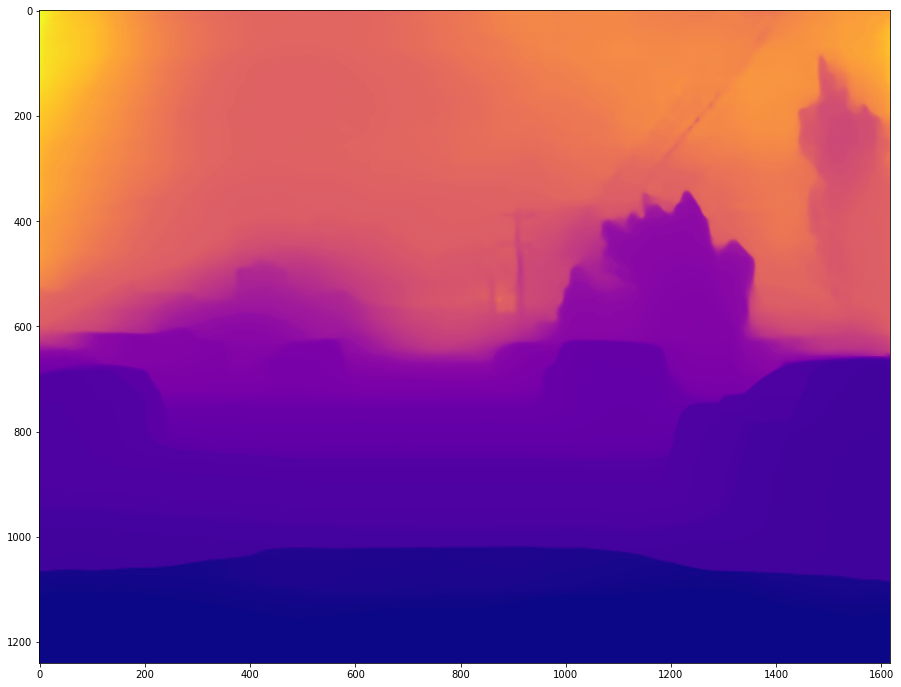

In [ ]:
img = frame
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

with torch.no_grad():
  prediction = midas(input_batch)

  prediction = torch.nn.functional.interpolate(
    prediction.unsqueeze(1),
    size=img.shape[:2],
    mode="bicubic",
    align_corners=False,
  ).squeeze()

output = prediction.cpu().numpy()
# output=expand(50*output/np.max(output)) # for better visualization
output=conv(50*output/np.max(output))  # to get values in meters
fig = plt.figure(figsize=(16,12))
plt.imshow(output,cmap='plasma')

# plt.imshow(frame, cmap='plasma')

50.119955593482


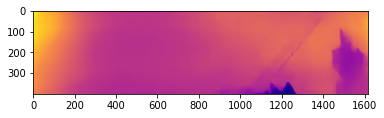

In [ ]:
# print(output[0:400])
plt.imshow(output[0:400,:],cmap='plasma')
print(np.max(output))

50.119955593482


(array([2.68426e+05, 4.73930e+04, 2.57900e+03, 1.16900e+03, 2.24910e+04,
        1.70670e+05, 1.77212e+05, 3.80810e+04, 4.12260e+04, 8.51810e+04,
        1.52860e+04, 2.49760e+04, 4.72390e+04, 5.35950e+04, 4.32650e+04,
        1.21300e+04, 1.62150e+04, 1.20180e+04, 1.13480e+04, 1.07280e+04,
        1.02360e+04, 1.07590e+04, 1.33290e+04, 1.55890e+04, 2.03290e+04,
        2.79330e+04, 3.03830e+04, 4.53450e+04, 7.15710e+04, 1.44216e+05,
        1.16217e+05, 5.76120e+04, 5.15620e+04, 4.51410e+04, 4.43050e+04,
        7.11840e+04, 3.45320e+04, 2.99060e+04, 1.52520e+04, 1.33930e+04,
        6.51600e+03, 5.81100e+03, 4.71900e+03, 4.41600e+03, 4.22200e+03,
        3.32700e+03, 2.48100e+03, 1.29800e+03, 7.60000e+02, 2.68000e+02]),
 array([1.75000000e-02, 1.01954911e+00, 2.02159822e+00, 3.02364734e+00,
        4.02569645e+00, 5.02774556e+00, 6.02979467e+00, 7.03184378e+00,
        8.03389289e+00, 9.03594201e+00, 1.00379911e+01, 1.10400402e+01,
        1.20420893e+01, 1.30441385e+01, 1.40461876e+

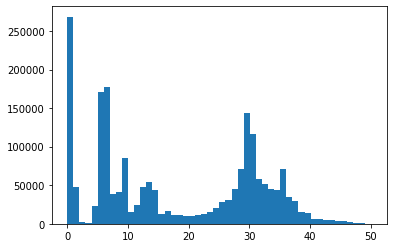

In [ ]:
flat_out = output.flatten()
print(np.max(flat_out))
plt.hist(flat_out, bins = 50)

# Create Point Cloud

In [ ]:
import math

def depth2pcd(depth):
    width = depth.shape[1]
    height = depth.shape[0]
    fx= 926.9796142578125
    fy= 924.431884765625
    cx= 790.234375
    cy= 617.5499267578125
    points = []
    # fig = plt.figure()

    for v in range(0, width, 10):
        for u in range(0, height, 10):
            Z = depth[u][v]
            if Z == 0:
                continue
            X_cam = (v - cx)
            
            Y_cam = -(u - cy)
            
            X = X_cam/fx*Z
            Y = Y_cam/fy*Z
            # if Y>0 and Y<5:
            points.append([X, Y, Z])
            
    return np.array(points)

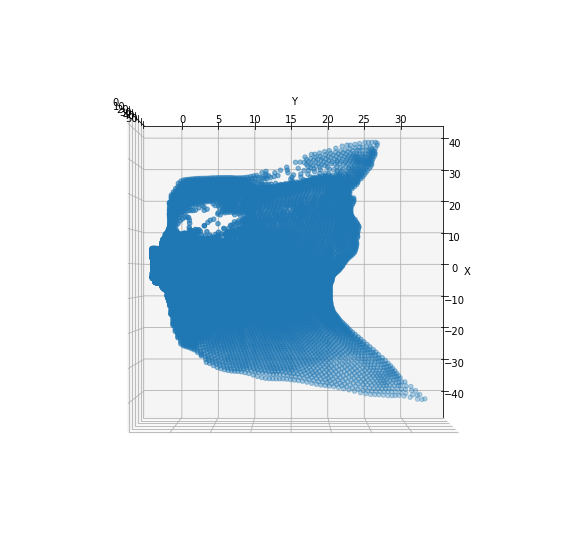

In [ ]:
pc_3d = depth2pcd(output)
# print(pc_3d)


x = pc_3d[:, 0]
y = pc_3d[:, 1]
z = pc_3d[:, 2]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.view_init(270,0)
ax.scatter(x,y,z)
plt.xlabel('X')
plt.ylabel('Y')
# plt.zlabel('Z')
plt.show()


Text(0, 0.5, 'X')

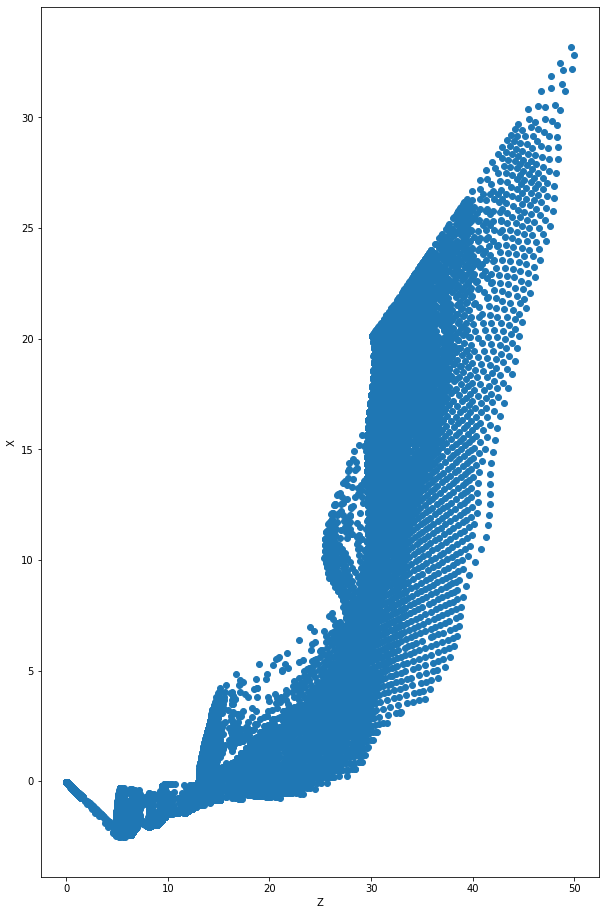

In [ ]:
fig = plt.figure(figsize=(10,16))
plt.scatter(z,y)
plt.xlabel('Z')
plt.ylabel('X')

Text(0, 0.5, 'X')

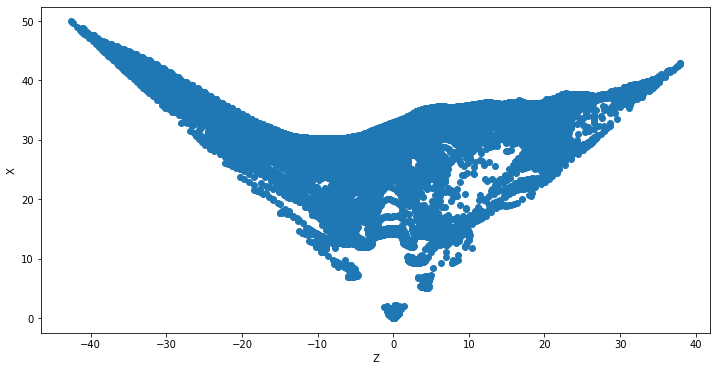

In [ ]:
x_trunc = []
y_trunc = []
z_trunc = []

for i in range(len(x)):
  if y[i]>-1:
    x_trunc.append(x[i])
    y_trunc.append(y[i])
    z_trunc.append(z[i])

fig = plt.figure(figsize=(12,6))
plt.scatter(x_trunc,z_trunc)
plt.xlabel('Z')
plt.ylabel('X')

In [ ]:
frames = []
def depth_prediction_stream_3D(image, frame, index):
    """Visualizes segmentation overlay view and stream it with IPython display."""
    img = frame
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    input_batch = transform(img).to(device)

    with torch.no_grad():
      prediction = midas(input_batch)

      prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
      ).squeeze()

    output = prediction.cpu().numpy()
    # output=expand(50*output/np.max(output)) # for better visualization
    output=conv(50*output/np.max(output))  # to get values in meters

    # plt.imshow(output, cmap='plasma')

    pc_3d = depth2pcd(output)
    x = pc_3d[:, 0]
    y = pc_3d[:, 1]
    z = pc_3d[:, 2]
    fig = plt.figure(figsize=(12,6))
    plt.scatter(x,z)
    plt.xlabel('Z')
    plt.ylabel('X')
    plt.xlim(-60, 60)
    plt.ylim(0, 60) 

    plt.savefig('saved_figure.jpg')
    im = cv.imread('saved_figure.jpg')
    frames.append(im)
    plt.close()

def depth_prediction_video_3D(frame, index):
    """Inferences DeepLab model on a video file and stream the visualization."""
    original_im = Image.fromarray(frame[..., ::-1])
    depth_prediction_stream_3D(original_im, frame, index)

In [ ]:
frames=[]
video = cv.VideoCapture(SAMPLE_VIDEO)
# num_frames = 598  # uncomment to use the full sample video
num_frames = 50 
try:
    for i in range(num_frames):
        _, frame = video.read()
        if not _: break
        depth_prediction_video_3D(frame, i)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")


height, width, layers = frames[0].shape
size = (width,height)
fourcc = cv.VideoWriter_fourcc(*'MJPG')
out = cv.VideoWriter('3D_pointcloud.avi', fourcc, 20.0, size)
 
for i in range(len(frames)):
    out.write(frames[i])
out.release()

In [ ]:
plt.imshow(frames[9])

# Image Segmentation + Depth Prediction

In [ ]:
def depth2pcd_segm(depth,seg_map):
    width = depth.shape[1]
    height = depth.shape[0]
    fx= 926.9796142578125
    fy= 924.431884765625
    cx= 790.234375
    cy= 617.5499267578125
    points = []
    # fig = plt.figure()
    objects_needed = {'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle'}
    # objects_car = {  'person', 'rider', 'car', 'truck',
    # 'bus', 'train', 'motorcycle', 'bicycle'}
    objects_car = {'car'}


    for v in range(0, width, 10):
        for u in range(0, height, 10):
        # for u in range(0, 1000, 10):
            Z = depth[u][v]
            color = seg_map[u][v]
            if Z == 0:
                continue
            X_cam = (v - cx)
            
            Y_cam = -(u - cy)
            
            X = X_cam/fx*Z
            Y = Y_cam/fy*Z
            if LABEL_NAMES[color] in objects_car:
              points.append([X, Y, Z,color])
            # points.append([X, Y, Z,color])
            
    return np.array(points)

In [ ]:
def prediction_stream(image, seg_map, seg_data, frame, index):
    """Visualizes segmentation overlay view and stream it with IPython display."""
    for i in range(len(seg_map)):
        for j in range(len(seg_map[i])):
                seg_data[i][j] = LABEL_NAMES[seg_map[i][j]]
                

    
    img = frame
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    input_batch = transform(img).to(device)

    with torch.no_grad():
      prediction = midas(input_batch)

      prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
      ).squeeze()

    output = prediction.cpu().numpy()
    # output=expand(50*output/np.max(output)) # for better visualization
    output=conv(50*output/np.max(output))  # to get values in meters

    # plt.imshow(output, cmap='plasma')

    pc_3d = depth2pcd_segm(output,seg_map)
    x = pc_3d[:, 0]
    y = pc_3d[:, 1]
    z = pc_3d[:, 2]
    color = pc_3d[:, 3]
    color_plot = np.zeros((len(color),3))
    for i in range(len(color)):
      color_plot[i] = COLOR_MAP[int(color[i])]

    fig = plt.figure(figsize=(12,6))
    plt.scatter(x,z,c=color_plot/255,s=0.1)
    plt.xlabel('Z')
    plt.ylabel('X')
    plt.xlim(-30, 30)
    plt.ylim(0, 30) 

    plt.savefig('saved_figure.jpg')
    im = cv.imread('saved_figure.jpg')
    frames.append(im)
    plt.close()
    # plt.imshow(expand(output), cmap='plasma')
    # A = np.stack([seg_data,output])
    A = np.stack([seg_map,output])

    # # Show visualization in a streaming fashion.
    # f = BytesIO()
    # plt.savefig(f, format='jpeg')
    # IPython.display.display(IPython.display.Image(data=f.getvalue()))
    # f.close()
    # plt.close()
    return A
def prediction_video(frame, index):
    """Inferences DeepLab model on a video file and stream the visualization."""
    original_im = Image.fromarray(frame[..., ::-1])
    seg_map = MODEL.run(original_im)
    seg_data = np.full((len(seg_map),len(seg_map[0])),'nullvoidnada')
    filled_seg_data = prediction_stream(original_im, seg_map, seg_data, frame, index)
    # print(filled_seg_data)
    return filled_seg_data

In [ ]:
frames = []

SAMPLE_VIDEO = 'test12.mp4'
print('running deeplab on the sample video...')

video = cv.VideoCapture(SAMPLE_VIDEO)
# num_frames = 598  # uncomment to use the full sample video
num_frames = 100

try:
    for i in range(num_frames):
        _, frame = video.read()
        if not _: break
        filled_seg_DATA = prediction_video(frame, i)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")
# print(filled_seg_DATA)


height, width, layers = frames[0].shape
size = (width,height)
fourcc = cv.VideoWriter_fourcc(*'MJPG')
out = cv.VideoWriter('3D_pointcloud_car.avi', fourcc, 20.0, size)
 
for i in range(len(frames)):
    out.write(frames[i])
out.release()

running deeplab on the sample video...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


# Image Segmentation + Depth Prediction - Angle Visualization

In [ ]:
import math

def depth2pcd_segm(depth,seg_map):
    width = depth.shape[1]
    height = depth.shape[0]
    fx= 926.9796142578125
    fy= 924.431884765625
    cx= 790.234375
    cy= 617.5499267578125
    points = []
    # fig = plt.figure()
    objects_needed = {'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle'}

    objects_car = {'car'}


    for v in range(0, width, 10):
        for u in range(0, height, 10):
            Z = depth[u][v]
            color = seg_map[u][v]
            if Z == 0:
                continue
            X_cam = (v - cx)
            
            Y_cam = -(u - cy)
            
            X = X_cam/fx*Z
            Y = Y_cam/fy*Z
            ang = math.degrees(math.atan2(X,Z))
            if LABEL_NAMES[color] in objects_car:
              points.append([X, Y, Z,color,ang])
            
    return np.array(points)

In [ ]:
def ang2color(angle):
  Max_ang = np.max(angle)
  Min_ang = np.min(angle)

  color = 255*(angle-Min_ang)/(Max_ang-Min_ang)
  return color.astype(int)

In [ ]:
def prediction_stream(image, seg_map, seg_data, frame, index):
    """Visualizes segmentation overlay view and stream it with IPython display."""
    for i in range(len(seg_map)):
        for j in range(len(seg_map[i])):
                seg_data[i][j] = LABEL_NAMES[seg_map[i][j]]
                

    
    img = frame
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    input_batch = transform(img).to(device)

    with torch.no_grad():
      prediction = midas(input_batch)

      prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
      ).squeeze()

    output = prediction.cpu().numpy()
    # output=expand(50*output/np.max(output)) # for better visualization
    output=conv(50*output/np.max(output))  # to get values in meters

    # plt.imshow(output, cmap='plasma')

    pc_3d = depth2pcd_segm(output,seg_map)
    x = pc_3d[:, 0]
    y = pc_3d[:, 1]
    z = pc_3d[:, 2]
    color = pc_3d[:, 3]
    angle = pc_3d[:, 4]
    # color_plot = np.zeros((len(color),3))
    # for i in range(len(color)):
    #   color_plot[i] = COLOR_MAP[int(color[i])]
    angle_color = ang2color(angle)
    # print(len(angle_color))
    angle_color = np.vstack([np.zeros((2,len(angle_color))),angle_color])
    # angle_color = angle_color@[0, 0 ,1]
    # print(len(angle_color.T))

    fig = plt.figure(figsize=(12,6))
    plt.scatter(x,z,c=angle_color.T/255)
    plt.xlabel('Z')
    plt.ylabel('X')
    plt.xlim(-30, 30)
    plt.ylim(0, 30) 

    plt.savefig('saved_figure.jpg')
    im = cv.imread('saved_figure.jpg')
    frames.append(im)
    plt.close()
    # plt.imshow(expand(output), cmap='plasma')
    # A = np.stack([seg_data,output])
    A = np.stack([seg_map,output])

    # # Show visualization in a streaming fashion.
    # f = BytesIO()
    # plt.savefig(f, format='jpeg')
    # IPython.display.display(IPython.display.Image(data=f.getvalue()))
    # f.close()
    # plt.close()
    return A
def prediction_video(frame, index):
    """Inferences DeepLab model on a video file and stream the visualization."""
    original_im = Image.fromarray(frame[..., ::-1])
    seg_map = MODEL.run(original_im)
    seg_data = np.full((len(seg_map),len(seg_map[0])),'nullvoidnada')
    filled_seg_data = prediction_stream(original_im, seg_map, seg_data, frame, index)
    # print(filled_seg_data)
    return filled_seg_data

In [ ]:
frames = []

SAMPLE_VIDEO = 'test12.mp4'
print('running deeplab on the sample video...')

video = cv.VideoCapture(SAMPLE_VIDEO)
# num_frames = 598  # uncomment to use the full sample video
num_frames = 100

try:
    for i in range(num_frames):
        _, frame = video.read()
        if not _: break
        filled_seg_DATA = prediction_video(frame, i)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")
# print(filled_seg_DATA)


height, width, layers = frames[0].shape
size = (width,height)
fourcc = cv.VideoWriter_fourcc(*'MJPG')
out = cv.VideoWriter('3D_pointcloud_car_angleColor_5.avi', fourcc, 20.0, size)
 
for i in range(len(frames)):
    out.write(frames[i])
out.release()

running deeplab on the sample video...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


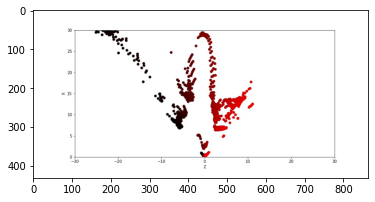

In [ ]:
plt.imshow(frames[9])